<a href="https://colab.research.google.com/github/srv-sh/Pytorch_tutorial/blob/main/FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor , Lambda , Compose
import matplotlib.pyplot as plt

In [ ]:
#Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True ,
    transform = ToTensor()
)

test_data = datasets.FashionMNIST(
    root = "data",
    train= False,
    download = True,
    transform = ToTensor()
)


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


We pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset, and supports autometic batching , sampling, shuffling and multiprocess data loading. Here we define a batch size of 64,i.e. each element in the dataloader iterable will return a batch of 64 feature and labels.

In [ ]:
batch_size = 64

#create data loader
train_dataloader = DataLoader(training_data , batch_size=batch_size )
test_dataloader = DataLoader(test_data , batch_size= batch_size)

for X,y in test_dataloader:
  print("Shape of X [N ,C,H,W]", X.shape)
  print("Shape of y [N,C,H,W]", y. shape)
  break

Shape of X [N ,C,H,W] torch.Size([64, 1, 28, 28])
Shape of y [N,C,H,W] torch.Size([64])


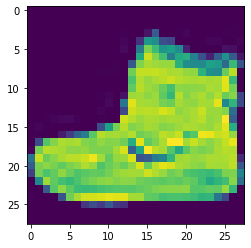

In [ ]:
x,y = training_data[0]
plt.imshow(x.squeeze())

# Creating Models
To define a neural network in pyTorcch, we create a class that inherits from nn.Modules. We define the layers of the network in the _ _init_ _ function and specify how data will pass through the network in the forward function. To accelerate operations in the neural network, we move it to the GPU if available.

In [ ]:
# Get cpu or GPU device for training 
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using{} device".format(device))

#Define Model 
class NeuralNetwork(nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(28*28,512),
        nn.ReLU(),
        nn.Linear(512,512),
        nn.ReLU(),
        nn.Linear(512,10),
        nn.ReLU() )
  def forward(self,x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

model = NeuralNetwork().to(device)
print(model)

Usingcpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


# Optimizing The Model Parameters
To train a model, we need a loss function and an optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 1e-3)

In a single training loop , the model makes predictions on the training dataset (fed to it in batches), and backpropagates the pridiction error to adjust the models's parameters

In [ ]:
def train(dataloader , model , loss_fn , optimizer):
  size = len(dataloader.dataset)
  for batch, (X,y) in enumerate(dataloader):
    X, y  = X.to(device) , y.to(device)

    #compute prediction error
    pred = model(X)
    loss = loss_fn(pred , y)

    #Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      loss, current = loss.item() , batch * len(X)
      print(f"loss {loss:>7f} [{current: >5d}/{size:>5d}]")
      

# Also check the model's performance against the test datasets to ensure it is learning.

In [ ]:
def test(dataloader , model, loss_fn):
  size = len(dataloader.dataset)
  model.eval()
  test_loss , correct =0,0
  with torch.no_grad():
    for X,y in dataloader:
      X, y = X.to(device) , y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred , y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= size
  correct /= size
  print(f"Test Error: \n Accuracy:{(100*correct):>0.1f}% , Avg loss: {test_loss:>8f}\n")


the training process is conducted over several iteratins (epochs). During each epoch, the model learns parameters to make better predictions. We print the models accuracy and loss at each epoch; we'd like to see the accuracy increse and the loss decrese with every epoch.

In [ ]:
epochs = 5
for t in range(epochs):
  print(f"Epoch {t+1}\n ------------------------")
  train(train_dataloader , model , loss_fn , optimizer)
  test(test_dataloader , model, loss_fn) 
print("done")


Epoch 1
 ------------------------
loss 2.214986 [    0/60000]
loss 2.206427 [ 6400/60000]
loss 2.183808 [12800/60000]
loss 2.194660 [19200/60000]
loss 2.148832 [25600/60000]
loss 2.125390 [32000/60000]
loss 2.141289 [38400/60000]
loss 2.110546 [44800/60000]
loss 2.095596 [51200/60000]
loss 2.027451 [57600/60000]
Test Error: 
 Accuracy:51.1% , Avg loss: 0.032607

Epoch 2
 ------------------------
loss 2.083847 [    0/60000]
loss 2.068007 [ 6400/60000]
loss 2.026662 [12800/60000]
loss 2.057947 [19200/60000]
loss 1.960098 [25600/60000]
loss 1.946454 [32000/60000]
loss 1.962485 [38400/60000]
loss 1.916877 [44800/60000]
loss 1.914397 [51200/60000]
loss 1.802073 [57600/60000]
Test Error: 
 Accuracy:50.4% , Avg loss: 0.029669

Epoch 3
 ------------------------
loss 1.903647 [    0/60000]
loss 1.885771 [ 6400/60000]
loss 1.824834 [12800/60000]
loss 1.882848 [19200/60000]
loss 1.752972 [25600/60000]
loss 1.754449 [32000/60000]
loss 1.771839 [38400/60000]
loss 1.724823 [44800/60000]
loss 1.73832

# Loading MOdels
The process for loading a model includes re-creating the model structure and loading the state dictionary into it.

In [ ]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

FileNotFoundError: ignored

This model can now be used to make predictions.

In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0] , test_data[0][1]
with torch.no_grad():
  pred = model(x)
  prediction , actual = classes[pred[0].argmax()] , classes[y]
  print(pred[0].argmax())
  print(f"Prediction'{prediction}', actually : '{actual}'")

tensor(8)
Prediction'Bag', actually : 'Ankle boot'
